In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/amazon-walmart-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-walmart-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in data.keys():
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-walmart-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-walmart-reduced/glove-300.matrix.npy',
                        text_columns = ['brand', 'groupname', 'title', 'shelfdescr',
                                        'shortdescr', 'longdescr'],
                        numeric_columns = ['price', 'shipweight', 'length', 'width', 'height'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=[],
                        text_compositions=['bi_lstm'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True,
                        dropout=0.5,
                        batch_norm=True,
                        lstm_args=dict(units=25, dropout=0, recurrent_dropout=0),
                        shared_lstm=True)

Number of inputs to dense layer: 199


# Crash recovery 

In [4]:
model.load_weights('../data/models/amazon-walmart-base-2-num-null')
df_hist = pd.read_csv('../data/histories/amazon-walmart-base-2-num-null.csv')

histories['acc'] = list(df_hist['acc'].values)
histories['val_acc'] = list(df_hist['val_acc'].values)
histories['loss'] = list(df_hist['loss'].values)
histories['val_loss'] = list(df_hist['val_loss'].values)

# Train model 

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=4096,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 93243 samples, validate on 11656 samples
Epoch 1/1
93243/93243 [==============================] - 168s 2ms/step - loss: 0.0053 - acc: 0.9990 - val_loss: 0.0171 - val_acc: 0.9980


In [41]:
y_test_pred = model.predict(X_test, batch_size=4096)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11541
          1       0.87      0.87      0.87       114

avg / total       1.00      1.00      1.00     11655

[[11526    15]
 [   15    99]]


# Learning curves

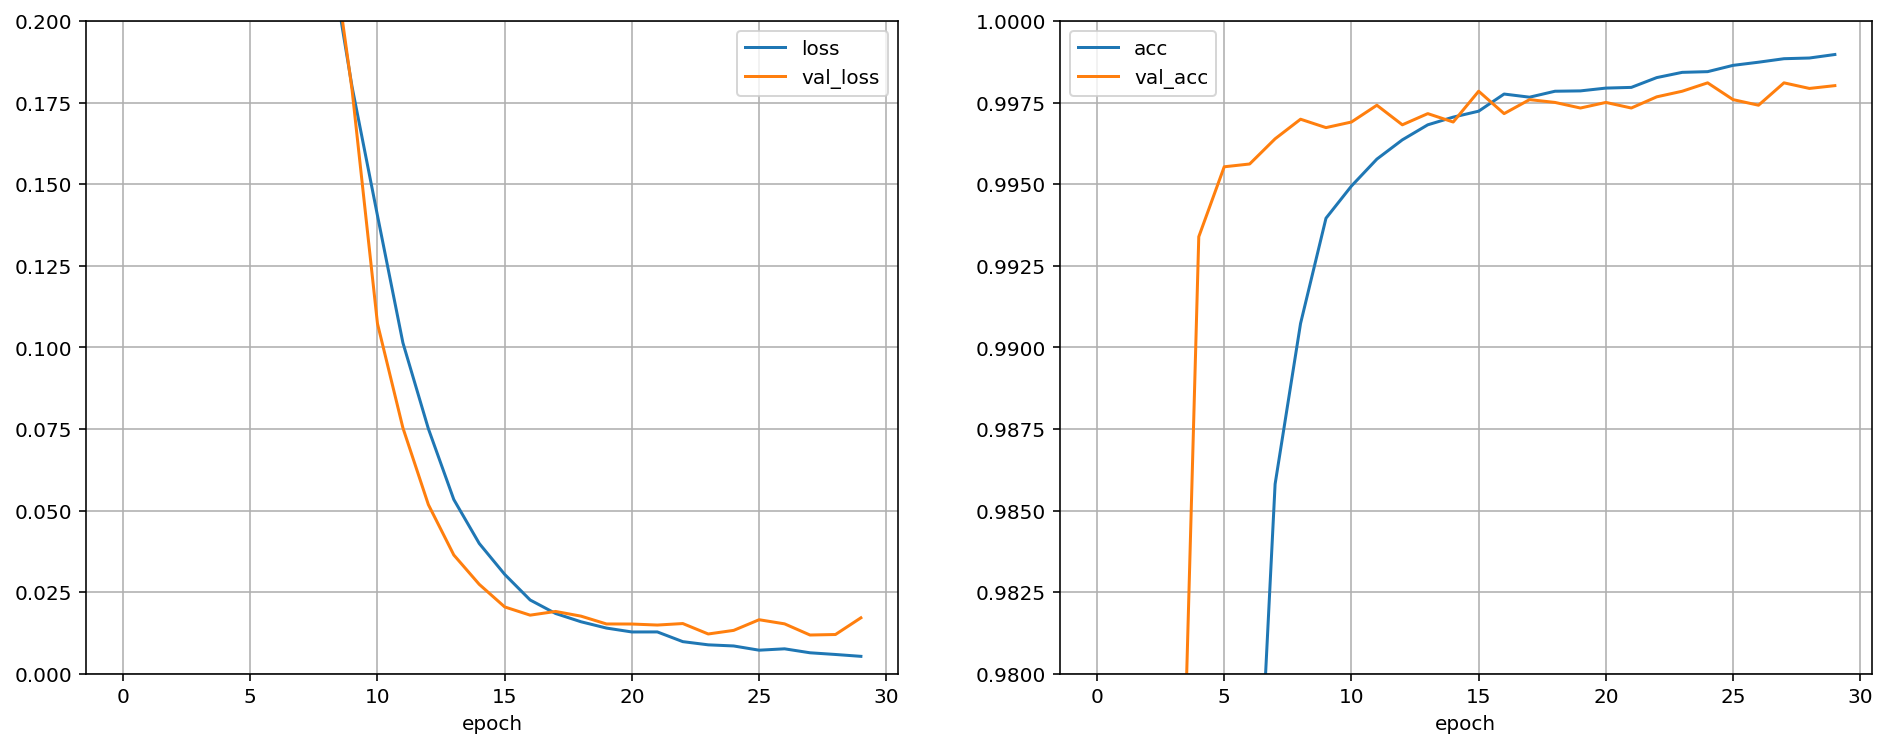

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set(ylim = (0, 0.2))
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set(ylim = (0.98, 1))

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [34]:
y_val_pred = model.predict(X_val, batch_size=4096)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11529
          1       0.92      0.91      0.91       127

avg / total       1.00      1.00      1.00     11656

[[11519    10]
 [   12   115]]


In [35]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & (y_val_pred >= 0.5)
columns = ['brand', 'groupname', 'title', 'shelfdescr',
           'shortdescr', 'longdescr']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(10)

,id1,brand,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,...,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,width,height
8951,3966,avery,labels stickers,avery tabs inches 48 tabs 16143,4.08,removable and durable tabs won smear when you write on them assorted colors stand out to help you find your place quickly use in personal organizers reports reference manuals books catalogs and more get free templates and software from avery website attaches temporarily to documents to provide fast easy access write on tabs with any kind of pen or marker ink won smear removable yet durable solid yellow or assorted colors attach temporarily to any document for quick and easy access,nan,make sure you re always in the right easily find your place in books reports catalogs and more with the help of these attach brightly colored tabs to help you flip back to specific flag important facts and figures gain quick access to favorite quotes or assign sections in notebook or personal and when you re done the tabs remove write on the tabs with virtually any writing instrument to remind yourself why you marked particular now you can always land right where you want to,0.0,7.2,...,stationery office machinery,avery tabs,3.54,removable won smear colors stand out,write on the the avery tabs with any writing instrument and the ink won the removable and durable self stick tabs are available in solid or assorted each sheet attaches temporarily to the document for quick and easy they re ideal for dividing and organizing documents such as personal organizers reports reference manuals books catalogs and the avery tabs assorted colors include yellow blue and,avery tabs removable and durable tabs won smear when you write on them assorted colors stand out use in personal organizers reports reference manuals books catalogs and more get free templates and software from color yellow blue and magenta size includes 48 tabs,0.05,7.25,3.000,0.300
9163,15438,sony,accessories supplies,sony blk headphones black,39.99,advanced design slim light weight angled design and variety of ear cushion sizes for improved comfort and adjustable cord conveniently control the cord length depending on where you interchangeable ear pads pick the size that maximizes comfort and sound performance for 9mm driver unit deep full bass performance in compact,nan,improved comfort with housing amp angled earbud position 9mm ex drivers deliver detailed amp rich sound reproduction with deep bass robust sound achieved by use of neodymium magnets cord adjuster for cord management type cord includes sizes of earbuds amp carrying pouch black,0.0,7.2,...,electronics general,sony premium ex earbuds mdrex57lp blk,39.99,frequency response 9mm closed driver units deep full bass sound,upgrade your music listening experience with the sony premium ex pleasure to wear these lightweight earbuds feature an angled design and come with three sizes of soft silicone earbuds to ensure the perfect fit and supreme your music will also sound amazing thanks to the 9mm driver units which deliver deep full bass additional features include type stereo mini plug cord adjuster extension cord and supplied carrying,sony premium ex earbuds mdrex57lp blk frequency response 9mm closed driver units deep full bass sound slim lightweight angled design for improved comfort and fit impedance 16 ohms power handling capacity 100mw includes extension cord cord adjuster sizes ear tips and carrying pouch color black,1.00,7.00,2.500,1.500
3835,11266,visiontek,keyboards mice input devices,visiontek candyboard wireless mini keyboard with touchpad 900319,84.99,innovative touchpad forget the mouse our innovative design lets you use the touch pad in the horiziontal or vertical rechargeable advanced battery technology allows for faster charge times longer usage and greater standby control your home theater unit from the comfort of your works with windowstm ps3tm xbox 360tm mac and linux complete qwerty 

# Save model and histories 

In [36]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-walmart-base-2-num-null.csv', index=False)
model.save_weights('../data/models/amazon-walmart-base-2-num-null')

# Test model 

In [4]:
model.load_weights('../data/models/amazon-walmart-base-2-num-null')
y_test_pred = model.predict(X_test, batch_size=4096)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99870   0.99913   0.99892     11541
          1    0.90826   0.86842   0.88789       114

avg / total    0.99782   0.99785   0.99783     11655

[[11531    10]
 [   15    99]]
